# Description of Dataset
MDB dataset having 50K movie reviews for natural language processing or Text analytics. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. It consists of a set of 25,000 highly polar movie reviews for training and 25,000 for testing. So,we have to predict the number of positive and negative reviews using either classification or deep learning algorithms.

## Loading necessary libraries

In [ ]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 31.8 MB/s 
     |████████████████████████████████| 6.6 MB 57.0 MB/s 
     |████████████████████████████████| 596 kB 58.3 MB/s 
     |████████████████████████████████| 84 kB 3.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import nltk
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from xgboost import XGBClassifier

from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re, string, unicodedata
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense,Input,Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D,Bidirectional, Flatten, BatchNormalization, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import transformers

In [ ]:
data=pd.read_csv('IMDB Dataset.csv')
df = data.copy()
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Exploratory Data Analysis, text cleaning, and Visualization

In [ ]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
# duplicates in the data
num_duplicates = df.duplicated().sum()
print("There are {} duplicate reviews present in the dataset".format(num_duplicates))

There are 418 duplicate reviews present in the dataset


In [ ]:
review = df['review']
duplicated_review = df[review.isin(review[review.duplicated()])].sort_values("review")
duplicated_review.head()

,review,sentiment
34058,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
47467,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
29956,"""Three"" is a seriously dumb shipwreck movie. M...",negative
31488,"""Three"" is a seriously dumb shipwreck movie. M...",negative
47527,"""Witchery"" might just be the most incoherent a...",negative


## Text Cleaning

StopWords:

Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc. Such words are already captured this in corpus named corpus. We first download it to our python environment.


In [ ]:
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuations = list(string.punctuation)
stop.update(punctuations)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Removing stop words
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Cleaning the data

In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_between_square_bracketsURL(text):
    return re.sub(r'http\S+', '', text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_between_square_bracketsURL(text)
    text = remove_stopwords(text)
    return text

# Applying function on review column
df['review'] = df['review'].apply(denoise_text)

In [ ]:
df.head()

,review,sentiment
0,one reviewers mentioned watching oz episode ex...,positive
1,wonderful little filming technique fashion giv...,positive
2,thought wonderful way spend time hot summer si...,positive
3,basically family little boy thinks zombie clos...,negative
4,petter time visually stunning film mattei offe...,positive


In [ ]:
# Converting sentiment column in numbers(i.e, 0s or 1s)

df.sentiment.replace("positive",1,inplace=True)
df.sentiment.replace("negative",0,inplace=True)

df.head(5)

,review,sentiment
0,one reviewers mentioned watching oz episode ex...,1
1,wonderful little filming technique fashion giv...,1
2,thought wonderful way spend time hot summer si...,1
3,basically family little boy thinks zombie clos...,0
4,petter time visually stunning film mattei offe...,1


# Data preprocecssing

In [ ]:
#splitting into train and test
train, test= df[:40000], df[40000:]
X_train, y_train = train['review'], train['sentiment']
X_test, y_test = test['review'], test['sentiment']

In [ ]:
#Vectorizing data

tfidf = TfidfVectorizer() #tfidfVectorizer
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Training Machine Learning models

---
## Cross Validation score vs Test accuracies:

The test result is more representative of the generalization ability of the model because it has never been used during the training process. However the cross-validation result is more representative because it represents the performance of the system on the 80% of the data instead of just the 20% of the training set. Moreover, if I change the split of my sets, the different test accuracies I get have a high variance but the average cross validation accuracy is more stable.


-----------

## Logistic Regression

Logistic Regression Accuracy:  87.75%


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      4876
           1       0.89      0.87      0.88      5124

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



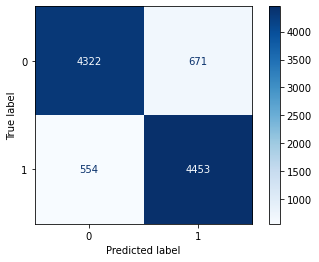

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)
pred_lr = lr.predict(X_test_tfidf)
score_lr = accuracy_score(y_test, pred_lr)
print("Logistic Regression Accuracy: ", "{:.2f}%".format(100*score_lr))
print("\n")
plot_confusion_matrix(lr, X_test_tfidf, y_test, cmap='Blues')
plt.grid(False)
print("Classification Report:\n")
print(classification_report(pred_lr,y_test))

## Multinomial Naive Bayes

Multinomial Naive Bayes Accuracy:  85.37%


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.84      0.86      5120
           1       0.84      0.86      0.85      4880

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



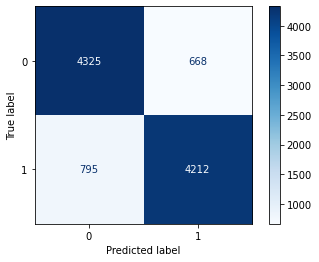

In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train_tfidf, y_train)
pred_mnb = mnb.predict(X_test_tfidf)
score_mnb = accuracy_score(y_test, pred_mnb)
print("Multinomial Naive Bayes Accuracy: ", "{:.2f}%".format(100*score_mnb))
print("\n")
plot_confusion_matrix(mnb, X_test_tfidf, y_test, cmap='Blues')
plt.grid(False)
print("Classification Report:\n")
print(classification_report(pred_mnb,y_test))

## Liner SVM

Linear Support Vectpr Classifier Accuracy:  87.80%


Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      4957
           1       0.88      0.88      0.88      5043

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



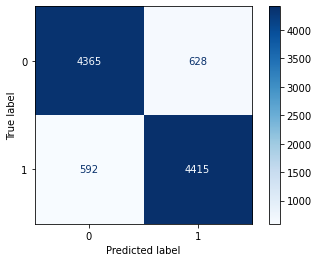

In [ ]:
svc = LinearSVC(penalty='l2',loss='hinge')
svc.fit(X_train_tfidf, y_train)
pred_svc = svc.predict(X_test_tfidf)
score_svc = accuracy_score(y_test, pred_svc)
svc_cvScore = cross_val_score(svc, X_train_tfidf, y_train, cv=5)
print("Linear Support Vectpr Classifier Accuracy: ", "{:.2f}%".format(100*score_svc))
print("\n")
plot_confusion_matrix(svc, X_test_tfidf, y_test, cmap='Blues')
plt.grid(False)
print("Classification Report:\n")
print(classification_report(pred_svc,y_test))

## Training the data with Neural Networks

In [ ]:
train, test = df[:40000], df[40000:]
X_train, y_train = train['review'], train['sentiment']
X_test, y_test = test['review'], test['sentiment']
#splitting the train set into train and validation

In [ ]:
X_train.shape, y_train.shape

((40000,), (40000,))

In [ ]:
#set up the tokenizer
MAX_VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE,oov_token="<oov>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
#print(word_index)
V = len(word_index)
print("Vocabulary of the dataset is : ",V)

Vocabulary of the dataset is :  76357


In [ ]:
##create sequences of reviews
seq_train = tokenizer.texts_to_sequences(X_train)
seq_test =  tokenizer.texts_to_sequences(X_test)

In [ ]:
#choice of maximum length of sequences
seq_len_list = [len(i) for i in seq_train + seq_test]

#if we take the direct maximum then
max_len=max(seq_len_list)
print('Maximum length of sequence in the list: {}'.format(max_len))

Maximum length of sequence in the list: 1171


In [ ]:
# when setting the maximum length of sequence, variability around the average is used.
max_seq_len = np.mean(seq_len_list) + 2 * np.std(seq_len_list)
max_seq_len = int(max_seq_len)
print('Maximum length of the sequence when considering data only two standard deviations from average: {}'.format(max_seq_len))

Maximum length of the sequence when considering data only two standard deviations from average: 226


In [ ]:
perc_covered = np.sum(np.array(seq_len_list) < max_seq_len) / len(seq_len_list)*100
print('The above calculated number coveres approximately {} % of data'.format(np.round(perc_covered,2)))

The above calculated number coveres approximately 94.53 % of data


In [ ]:
#create padded sequences
pad_train=pad_sequences(seq_train,truncating = 'post', padding = 'pre',maxlen=max_seq_len)
pad_test=pad_sequences(seq_test,truncating = 'post', padding = 'pre',maxlen=max_seq_len)

In [ ]:
X_train = pad_train

In [ ]:
def lstm_model(Xtrain,ytrain,V,D,maxlen,epochs):

    print("----Building the model----")
    i = Input(shape=(maxlen,))
    x = Embedding(V + 1, D,input_length = maxlen)(i)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(32,5,activation = 'relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(LSTM(128,return_sequences=True))(x)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    model.summary()

    #Training the LSTM
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_accuracy',
                                mode='min',
                               patience = 2 )

    checkpoints= tf.keras.callbacks.ModelCheckpoint(filepath='./',
                            monitor="val_accuracy",
                             save_best_only=True
                            )
    callbacks = [checkpoints,early_stop]
    r = model.fit(Xtrain,ytrain,
                  epochs = epochs,
                  verbose = 2,
                  batch_size = 32)
#                   callbacks = callbacks)
    return r,model


In [ ]:
D = 64 #embedding dims
epochs = 5
r,model = lstm_model(X_train,y_train,V,D,max_seq_len,epochs)

----Building the model----
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 226)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 226, 64)           4886912   
                                                                 
 batch_normalization_1 (Batc  (None, 226, 64)          256       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 226, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 222, 32)           10272     
                                                                 
 dropout_4 (Dropout)         (None, 222, 32)           0         
                                

## Model Evaluation

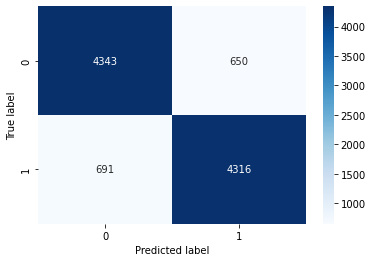

In [ ]:
# Confusion MAtrix
ypred = model.predict(pad_test)
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print("Classification Report:\n")
print(classification_report(y_test,ypred))

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.87      0.87      4993
           1       0.87      0.86      0.87      5007

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



---
#### Linear SVC peromed better than neural networks model. Now let's train with transformers.

# BERT

In [ ]:
# Tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
train, test= df[:40000], df[40000:]
X_train, y_train = train['review'], train['sentiment']
X_test, y_test = test['review'], test['sentiment']

In [ ]:
#pass our texts to the tokenizer.
Xtrain_enc = tokenizer(X_train.tolist(),
                       max_length=max_seq_len,
                       truncation=True,
                       padding='max_length',
                       add_special_tokens=True,
                       return_tensors='np') #return numpy object

Xtest_enc = tokenizer(X_test.tolist(),
                      max_length=max_seq_len,
                      truncation=True,
                      padding='max_length',
                      add_special_tokens=True,
                      return_tensors='np') #return numpy object

In [ ]:
# preparing our datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
            dict(Xtrain_enc),
            y_train
))

test_dataset = tf.data.Dataset.from_tensor_slices((
            dict(Xtest_enc),
            y_test
))

## BERT Model

In [ ]:
def bert_model(train_dataset,transformer,max_len,epochs):
    print("----Building the model----")
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(max_len,),dtype=tf.int32,name = 'attention_mask') #attention mask
    sequence_output = transformer(input_ids,attention_mask)[0]
    cls_token = sequence_output[:, 0, :]
    x = Dense(512, activation='relu')(cls_token)
    x = Dropout(0.1)(x)
    y = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[input_ids,attention_mask], outputs=y)
    model.summary()
    model.compile(Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    r = model.fit(train_dataset.batch(32),batch_size = 32,epochs = epochs)
                  #callbacks = callbacks

    return r,model

In [ ]:
from transformers import TFDistilBertModel
transformer = TFDistilBertModel.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'activation_13', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
epochs=2
max_len = max_seq_len
r, model = bert_model(train_dataset, transformer,max_len,epochs)

----Building the model----
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 226)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 226)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 226, 768),                                                   
                                 hidden_states=None              

## BERT model evaluation

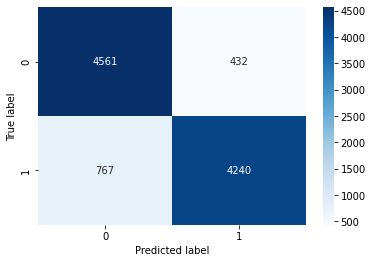

In [ ]:
#Generate predictions for the test dataset
ypred = model.predict(test_dataset.batch(32))
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
print("Classification Report:\n")
print(classification_report(y_test,ypred))

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.91      0.88      4993
           1       0.91      0.85      0.88      5007

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

